In [22]:
import os, sys
import random
import json

import astropy
from astropy.io import fits
from astropy.wcs import WCS

project_root = os.path.abspath("..")  # ou le chemin absolu du projet
sys.path.insert(0, project_root)


from src.core.xml_utils import create_xml_param
from src.core.file_transfer import send_xml_fits_to_server
from src.services.server_comm import poll_for_completion, download_result
from src.utils.cianna_xml_updater import update_cianna_models, get_model_info




In [30]:
IMAGE_FOLDER = "~/01_Observatoire/DIR_images"

# Use expanduser to get the absolute path
from os.path import expanduser
from pprint import pprint
IMAGE_FOLDER = expanduser(IMAGE_FOLDER)

images_list = [os.path.join(IMAGE_FOLDER, img) for img in os.listdir(IMAGE_FOLDER) \
          if img.endswith(".fits")]

print("Images list:")
pprint(images_list)

# Get one random image from the list
random_image = random.choice(images_list)
print(40 * "-")
# Get the name of the image without the extension
image_name = os.path.basename(random_image)

print(f"Image name randomly selected: {image_name}")


def get_image_dim(image_path):
    # Open the image and get the header
    with fits.open(random_image) as hdul:
        header = hdul[0].header
        data = hdul[0].data

        if data is None:
            info = {'type': 'No data', 'shape': (), 'axes': []}

        shape = tuple(s for s in data.shape if s > 1) # Remove "1" dimensions
        ndim = len(shape)

        if ndim == 2:
            image_type = '2D image'
        elif ndim == 3:
            image_type = '3D image'
        else:
            image_type = f'Unsupported ({ndim}D)'

        try:
            wcs = WCS(header)
            ctype = [wcs.wcs.ctype[i] for i in range(wcs.naxis) if data.shape[::-1][i] > 1]
        except Exception:
            ctype = []

        info = {
            'type': image_type,
            'shape': shape,
            'axes': ctype
        }
    return info

info = get_image_dim(random_image)
print("Image info:")
pprint(info)



Images list:
['/home/gsainton/01_Observatoire/DIR_images/RACS-DR1_0000+18A.fits',
 '/home/gsainton/01_Observatoire/DIR_images/RACS-DR1_0506-37A.fits',
 '/home/gsainton/01_Observatoire/DIR_images/RACS-DR1_0510+00A.fits',
 '/home/gsainton/01_Observatoire/DIR_images/RACS-DR1_0000+12A.fits']
----------------------------------------
Image name randomly selected: RACS-DR1_0510+00A.fits
Image info:
{'axes': ['RA---SIN', 'DEC--SIN'], 'shape': (13690, 13700), 'type': '2D image'}


Image type: 2D image


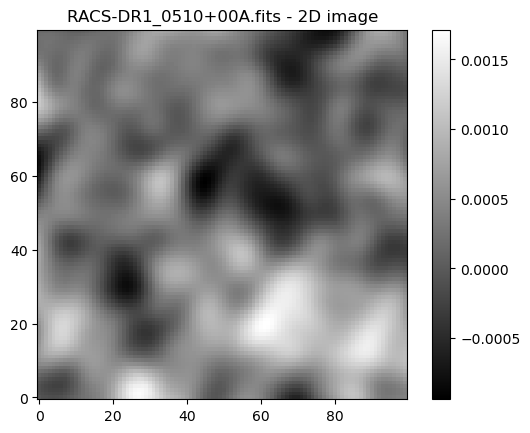

In [47]:
# Plot the image
import matplotlib.pyplot as plt
import numpy as np  
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
from astropy.visualization import PercentileInterval
from astropy.visualization import SqrtStretch

def plot_image(image_path, xmin, xmax, ymin, ymax):
    """
    Plot the image with a colorbar and title.
    
    Parameters:
    
    image_path (str): Path to the image file.
    xmin (int): Minimum x coordinate for the image.
    xmax (int): Maximum x coordinate for the image.
    ymin (int): Minimum y coordinate for the image.
    ymax (int): Maximum y coordinate for the image.

    """

    # Open the image and get the header
    with fits.open(image_path) as hdul:
        header = hdul[0].header
        #image_data = hdul[0].data
        image_data = hdul[0].data[0,0,ymin:ymax,xmin:xmax]
        if image_data is None:
            print("No data")
            return

        # Get the shape of the image
        shape = tuple(s for s in image_data.shape if s > 1) # Remove "1" dimensions
        ndim = len(shape)

        if ndim == 2:
            image_type = '2D image'
        elif ndim == 3:
            image_type = '3D image'
        else:
            image_type = f'Unsupported ({ndim}D)'

        print(f"Image type: {image_type}")
        
        # Plot the image
        fig, ax = plt.subplots()
        
        if ndim == 2:

            # remove "1" dimensions
            image_data = np.squeeze(image_data)

            im = ax.imshow(image_data, cmap='gray', origin='lower')
            plt.colorbar(im, ax=ax)
            plt.title(f"{image_name} - {image_type}")
            plt.show()
        elif ndim == 3:
            # Plot the first slice of the 3D image
            im = ax.imshow(image_data[0], cmap='gray', origin='lower')
            ax.set_xlabel('X axis')
            ax.set_ylabel('Y axis')
            plt.colorbar(im, ax=ax)
            plt.title(f"{image_name} - {image_type} (slice 0)")
            plt.show()
        else:
            print(f"Unsupported image type: {image_type}")
            return
    return
plot_image(random_image, 0, 100, 0, 100)

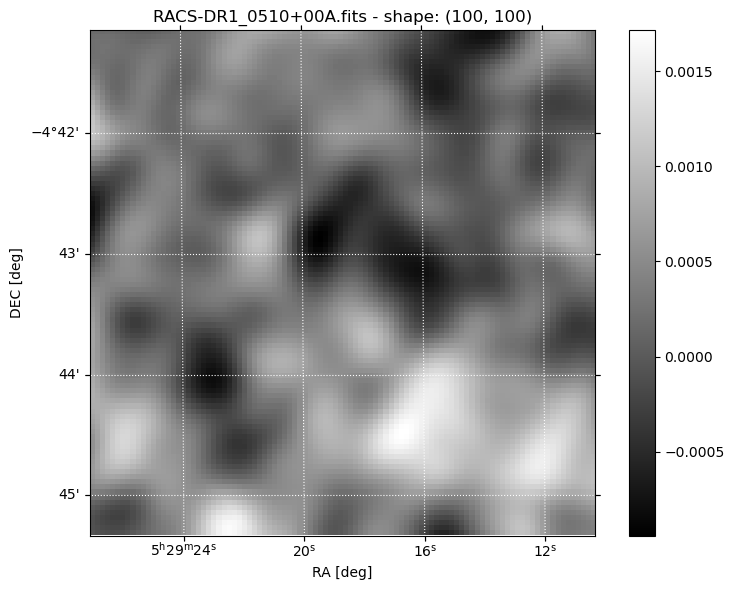

In [49]:

def plot_image2(image_path, xmin, xmax, ymin, ymax, slice_index=0):
    """
    Plot the image using WCS coordinates (RA/DEC in degrees), with cropping.

    Parameters:
    -----------
    image_path : str
        Path to the image file.
    xmin, xmax, ymin, ymax : int
        Pixel coordinates to crop the image.
    slice_index : int, optional
        Index to extract if the image is 3D or higher (default is 0).
    """
    with fits.open(image_path) as hdul:
        header = hdul[0].header
        data = np.squeeze(hdul[0].data)

        if data is None:
            print("No data found.")
            return

        # Determine the WCS dimensionality
        wcs_full = WCS(header)
        wcs_ndim = wcs_full.pixel_n_dim

        # Prepare WCS slices: fix all axes except the last two
        slices = []
        for i in range(wcs_ndim):
            if i < wcs_ndim - 2:
                slices.append(slice_index)  # fix non-spatial axes
            elif i == wcs_ndim - 2:
                slices.append(slice(ymin, ymax))  # Y axis
            else:
                slices.append(slice(xmin, xmax))  # X axis
        slices = tuple(slices)

        # Slice the data
        image_data = np.squeeze(hdul[0].data[slices])

        # Slice the WCS to match
        wcs_cut = wcs_full.slice(slices)

        # Plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection=wcs_cut)
        im = ax.imshow(image_data, cmap='gray', origin='lower')
        ax.set_xlabel('RA [deg]')
        ax.set_ylabel('DEC [deg]')
        ax.grid(color='white', ls='dotted')
        plt.colorbar(im, ax=ax)
        image_name = image_path.split('/')[-1]
        plt.title(f"{image_name} - shape: {image_data.shape}")
        plt.tight_layout()
        plt.show()

plot_image2(random_image, 0, 100, 0, 100)